## RESNET 18

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15 - Loss: 30.2526, Accuracy: 0.6309
Epoch 2/15 - Loss: 13.3288, Accuracy: 0.8548
Epoch 3/15 - Loss: 9.3163, Accuracy: 0.8890
Epoch 4/15 - Loss: 5.0539, Accuracy: 0.9402
Epoch 5/15 - Loss: 8.5407, Accuracy: 0.9032
Epoch 6/15 - Loss: 4.8176, Accuracy: 0.9469
Epoch 7/15 - Loss: 6.7499, Accuracy: 0.9250
Epoch 8/15 - Loss: 4.1057, Accuracy: 0.9583
Epoch 9/15 - Loss: 1.5101, Accuracy: 0.9877
Epoch 10/15 - Loss: 0.7247, Accuracy: 0.9924
Epoch 11/15 - Loss: 0.9007, Accuracy: 0.9877
Epoch 12/15 - Loss: 0.8127, Accuracy: 0.9915
Epoch 13/15 - Loss: 0.9600, Accuracy: 0.9896
Epoch 14/15 - Loss: 1.5445, Accuracy: 0.9820
Epoch 15/15 - Loss: 1.1660, Accuracy: 0.9867

📊 Validation Performance:
              precision    recall  f1-score   support

         pH5       0.83      0.77      0.80        96
         pH6       0.78      0.64      0.70        94
         pH7       0.64      0.81      0.71        93
         pH8       0.71      0.71      0.71        98

    accuracy                     

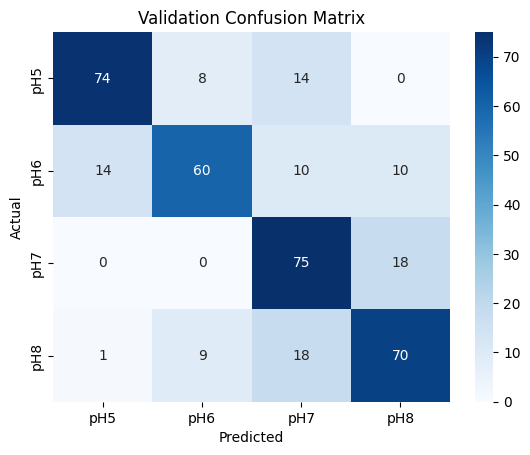


📊 Test Performance:
              precision    recall  f1-score   support

         pH5       0.82      0.83      0.82        99
         pH6       0.79      0.68      0.73        98
         pH7       0.74      0.87      0.80        94
         pH8       0.82      0.78      0.80        99

    accuracy                           0.79       390
   macro avg       0.79      0.79      0.79       390
weighted avg       0.79      0.79      0.79       390



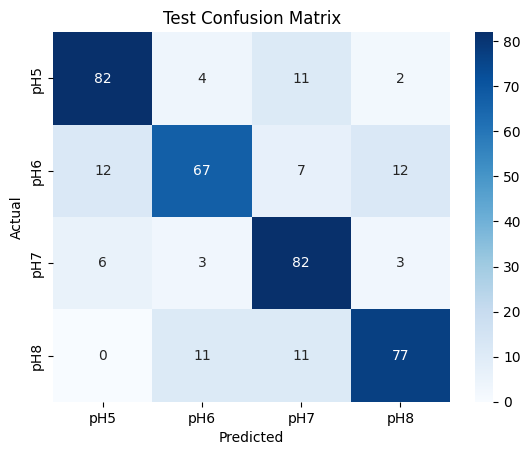

In [3]:
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration
data_dir = "Split_Data"  # Your dataset path
batch_size = 32
num_epochs = 15
num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Helper to load all time points together
def load_combined_dataset(split):
    datasets_list = []
    split_path = os.path.join(data_dir, split)
    for time_point in os.listdir(split_path):
        time_path = os.path.join(split_path, time_point)
        if os.path.isdir(time_path):
            ds = datasets.ImageFolder(time_path, transform=transform)
            datasets_list.append(ds)
    return torch.utils.data.ConcatDataset(datasets_list)

# Load datasets
train_dataset = load_combined_dataset("train")
val_dataset = load_combined_dataset("val")
test_dataset = load_combined_dataset("test")

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Model setup
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss, correct = 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    acc = correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")

# Evaluation function
def evaluate(loader, split_name):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels)

    print(f"\n📊 {split_name} Performance:")
    print(classification_report(all_labels, all_preds, target_names=["pH5", "pH6", "pH7", "pH8"]))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["pH5", "pH6", "pH7", "pH8"],
                yticklabels=["pH5", "pH6", "pH7", "pH8"], cmap="Blues")
    plt.title(f"{split_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Final evaluation
evaluate(val_loader, "Validation")
evaluate(test_loader, "Test")

In [4]:
# Save model
torch.save(model.state_dict(), 'resnet18_ph_classifier.pth')


ROC Curves for Validation Set:
Collected predictions for 381 samples


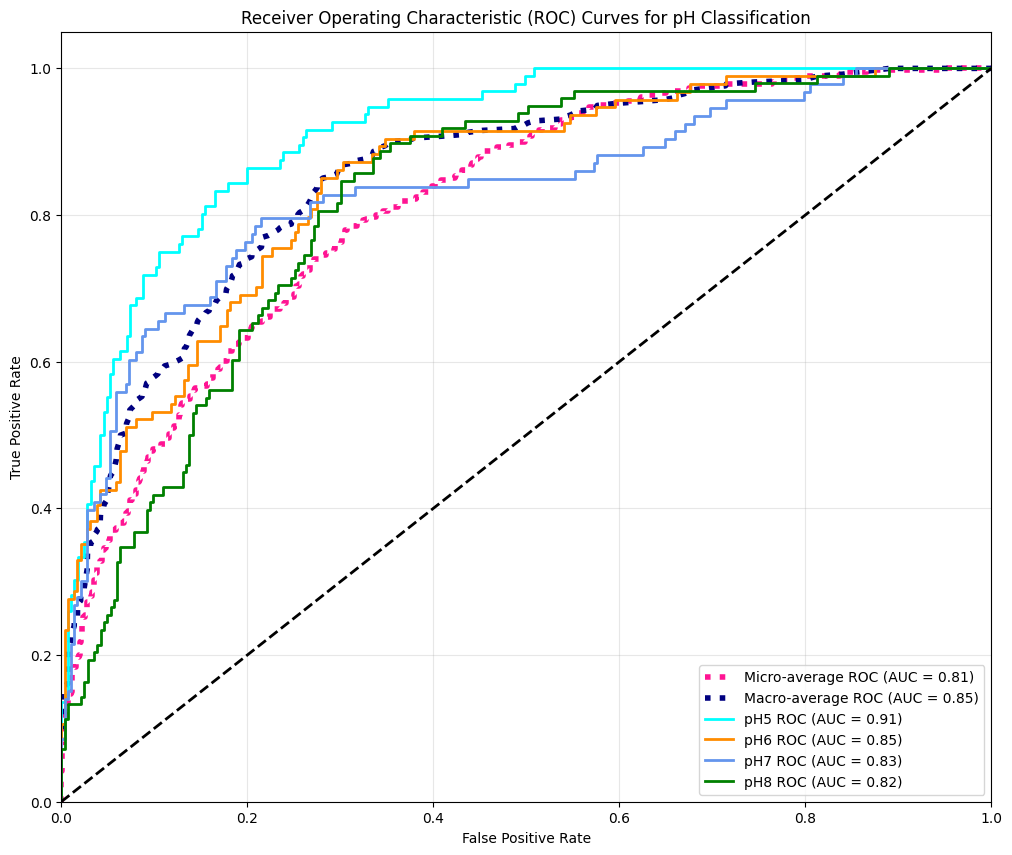


AUC Scores:
------------------------------
pH5: 0.9101
pH6: 0.8478
pH7: 0.8329
pH8: 0.8201
------------------------------
Micro-average: 0.8138
Macro-average: 0.8542

ROC Curves for Test Set:
Collected predictions for 390 samples


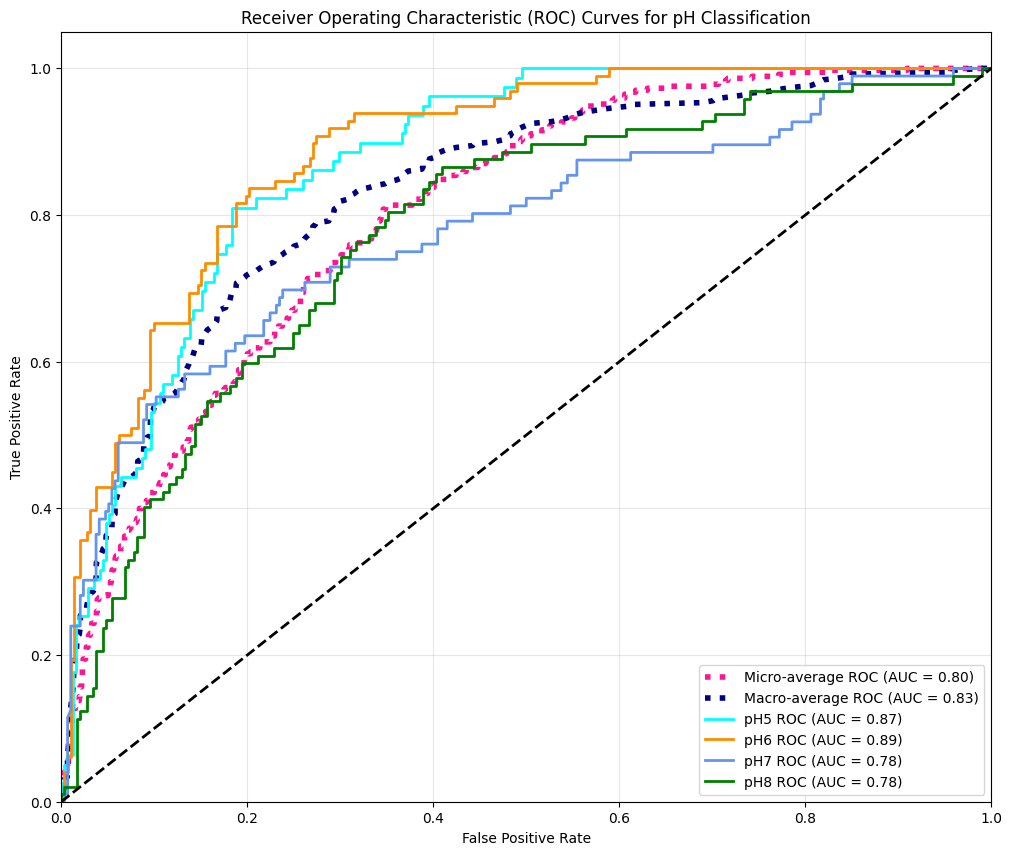


AUC Scores:
------------------------------
pH5: 0.8730
pH6: 0.8865
pH7: 0.7791
pH8: 0.7766
------------------------------
Micro-average: 0.8022
Macro-average: 0.8305


In [17]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import torch

def plot_roc_curves_timeaware(model, data_loader, class_names, device):
    """
    Plot ROC curves for a multi-class classification model that requires time features.
    This version is specifically adapted for TimeAwareResNet models.
    
    Args:
        model: Trained PyTorch TimeAwareResNet model
        data_loader: PyTorch DataLoader containing test/validation data
        class_names: List of class names (e.g., ["pH5", "pH6", "pH7", "pH8"])
        device: Device to run model on
    """
    model.eval()
    
    # For collecting predictions and true labels
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            # Check if batch is a list or tuple with multiple elements
            if isinstance(batch, (list, tuple)) and len(batch) >= 2:
                images = batch[0]
                labels = batch[1]
                
                # Check if time features are provided in the batch
                if len(batch) >= 3:
                    time_features = batch[2].to(device)
                else:
                    # Create dummy time features if not provided
                    # Adjust the shape based on your model's requirements
                    time_features = torch.zeros(images.size(0), 1).to(device)
                
                # Process the images
                images = images.to(device)
                
                # Forward pass with time features
                outputs = model(images, time_features)
                
            else:
                # Handle case where batch is a different format
                raise ValueError("Unexpected batch format. Expected a list or tuple with at least images and labels.")
            
            probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
            
            # Store results
            all_probs.append(probs)
            all_labels.append(labels.numpy())
    
    # Combine results from all batches
    all_probs = np.vstack(all_probs)
    all_labels = np.concatenate(all_labels)
    
    print(f"Collected predictions for {len(all_labels)} samples")
    
    # Get number of classes
    n_classes = len(class_names)
    
    # Create one-hot encoding of labels
    y_true = np.zeros((len(all_labels), n_classes))
    for i in range(len(all_labels)):
        if 0 <= all_labels[i] < n_classes:  # Ensure valid class index
            y_true[i, int(all_labels[i])] = 1
    
    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Calculate micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), all_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Calculate macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
    # Then interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure(figsize=(12, 10))
    
    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    
    # Plot macro-average ROC curve
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
             color='navy', linestyle=':', linewidth=4)
    
    # Plot ROC curves for all classes
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} ROC (AUC = {roc_auc[i]:.2f})')
    
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves for pH Classification')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    
    plt.show()
    
    # Print AUC scores
    print("\nAUC Scores:")
    print("-" * 30)
    for i in range(n_classes):
        print(f"{class_names[i]}: {roc_auc[i]:.4f}")
    print("-" * 30)
    print(f"Micro-average: {roc_auc['micro']:.4f}")
    print(f"Macro-average: {roc_auc['macro']:.4f}")
    
    return roc_auc

# Example usage
class_names = ["pH5", "pH6", "pH7", "pH8"]

# Plot ROC curves for validation set
print("\nROC Curves for Validation Set:")
val_roc = plot_roc_curves_timeaware(model, val_loader, class_names, device)

# Plot ROC curves for test set
print("\nROC Curves for Test Set:")
test_roc = plot_roc_curves_timeaware(model, test_loader, class_names, device)

## RESNET + RF

Epoch 1/15 - Loss: 33.1140, Accuracy: 0.5797
Epoch 2/15 - Loss: 16.4520, Accuracy: 0.7970
Epoch 3/15 - Loss: 9.9532, Accuracy: 0.8928
Epoch 4/15 - Loss: 6.3283, Accuracy: 0.9194
Epoch 5/15 - Loss: 6.4342, Accuracy: 0.9288
Epoch 6/15 - Loss: 4.5106, Accuracy: 0.9478
Epoch 7/15 - Loss: 3.2521, Accuracy: 0.9649
Epoch 8/15 - Loss: 2.4083, Accuracy: 0.9715
Epoch 9/15 - Loss: 3.3494, Accuracy: 0.9554
Epoch 10/15 - Loss: 4.7425, Accuracy: 0.9564
Epoch 11/15 - Loss: 2.7554, Accuracy: 0.9744
Epoch 12/15 - Loss: 2.5180, Accuracy: 0.9744
Epoch 13/15 - Loss: 2.6995, Accuracy: 0.9677
Epoch 14/15 - Loss: 1.3576, Accuracy: 0.9829
Epoch 15/15 - Loss: 0.8666, Accuracy: 0.9934

📊 Validation Performance:
              precision    recall  f1-score   support

         pH5       0.55      0.90      0.68        96
         pH6       0.77      0.61      0.68        94
         pH7       0.87      0.51      0.64        93
         pH8       0.75      0.73      0.74        98

    accuracy                     

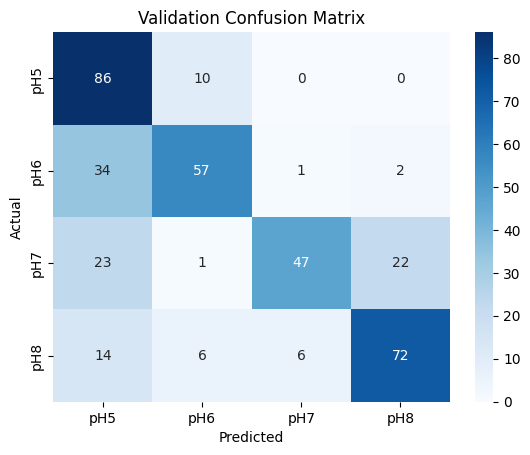


📊 Test Performance:
              precision    recall  f1-score   support

         pH5       0.56      0.89      0.69        99
         pH6       0.71      0.72      0.72        98
         pH7       0.88      0.56      0.69        94
         pH8       0.88      0.65      0.74        99

    accuracy                           0.71       390
   macro avg       0.76      0.71      0.71       390
weighted avg       0.76      0.71      0.71       390



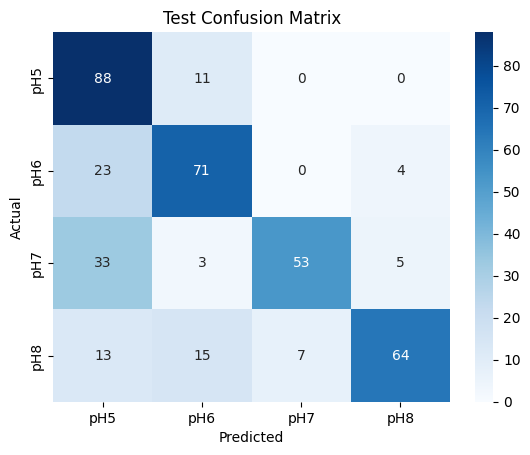


🔍 Extracting features for Random Forest...


/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🌲 Training Random Forest on extracted features...

🌲 RF - Validation Performance:
              precision    recall  f1-score   support

         pH5       0.70      0.86      0.77        96
         pH6       0.80      0.56      0.66        94
         pH7       0.79      0.62      0.70        93
         pH8       0.70      0.88      0.78        98

    accuracy                           0.73       381
   macro avg       0.75      0.73      0.73       381
weighted avg       0.75      0.73      0.73       381



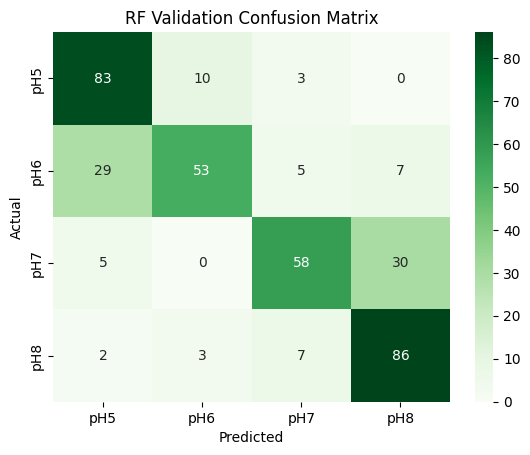


🌲 RF - Test Performance:
              precision    recall  f1-score   support

         pH5       0.74      0.85      0.79        99
         pH6       0.86      0.68      0.76        98
         pH7       0.82      0.80      0.81        94
         pH8       0.81      0.88      0.84        99

    accuracy                           0.80       390
   macro avg       0.81      0.80      0.80       390
weighted avg       0.81      0.80      0.80       390



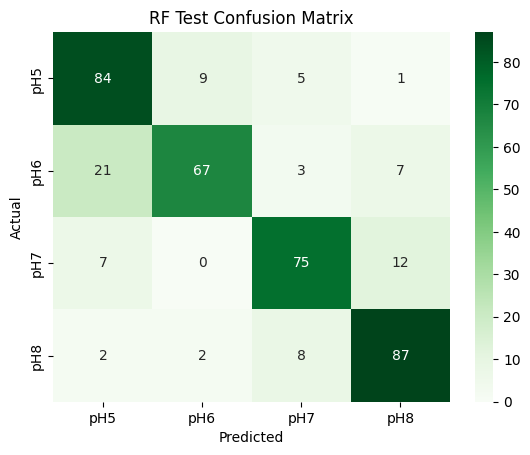

In [3]:
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Configuration
data_dir = "Split_Data"
batch_size = 32
num_epochs = 15
num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets from all time points
def load_combined_dataset(split):
    datasets_list = []
    split_path = os.path.join(data_dir, split)
    for time_point in os.listdir(split_path):
        time_path = os.path.join(split_path, time_point)
        if os.path.isdir(time_path):
            ds = datasets.ImageFolder(time_path, transform=transform)
            datasets_list.append(ds)
    return torch.utils.data.ConcatDataset(datasets_list)

train_dataset = load_combined_dataset("train")
val_dataset = load_combined_dataset("val")
test_dataset = load_combined_dataset("test")

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Model setup
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss, correct = 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    acc = correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")

# Evaluation function
def evaluate(loader, split_name):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels)

    print(f"\n📊 {split_name} Performance:")
    print(classification_report(all_labels, all_preds, target_names=["pH5", "pH6", "pH7", "pH8"]))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["pH5", "pH6", "pH7", "pH8"],
                yticklabels=["pH5", "pH6", "pH7", "pH8"], cmap="Blues")
    plt.title(f"{split_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Final evaluation
evaluate(val_loader, "Validation")
evaluate(test_loader, "Test")

# ----------------------------------
# 🔁 RANDOM FOREST USING RESNET FEATURES
# ----------------------------------

print("\n🔍 Extracting features for Random Forest...")

# Load feature extractor and THEN remove the classifier
feature_extractor = models.resnet18(pretrained=True)
feature_extractor.fc = nn.Linear(feature_extractor.fc.in_features, num_classes)
feature_extractor.load_state_dict(model.state_dict())  # Load trained weights
feature_extractor.fc = nn.Identity()  # Remove classifier for feature extraction
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

# Feature extraction function
def extract_features(dataloader):
    features, labels = [], []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            feats = feature_extractor(images).cpu().numpy()
            features.extend(feats)
            labels.extend(lbls.numpy())
    return np.array(features), np.array(labels)

X_train_rf, y_train_rf = extract_features(train_loader)
X_val_rf, y_val_rf = extract_features(val_loader)
X_test_rf, y_test_rf = extract_features(test_loader)

# Flatten features
X_train_rf = X_train_rf.reshape(X_train_rf.shape[0], -1)
X_val_rf = X_val_rf.reshape(X_val_rf.shape[0], -1)
X_test_rf = X_test_rf.reshape(X_test_rf.shape[0], -1)

# Train Random Forest
print("🌲 Training Random Forest on extracted features...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_rf, y_train_rf)

# Evaluate Random Forest
def evaluate_rf(X, y, split_name):
    preds = rf.predict(X)
    print(f"\n🌲 RF - {split_name} Performance:")
    print(classification_report(y, preds, target_names=["pH5", "pH6", "pH7", "pH8"]))

    cm = confusion_matrix(y, preds)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["pH5", "pH6", "pH7", "pH8"],
                yticklabels=["pH5", "pH6", "pH7", "pH8"], cmap="Greens")
    plt.title(f"RF {split_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_rf(X_val_rf, y_val_rf, "Validation")
evaluate_rf(X_test_rf, y_test_rf, "Test")


📉 Generating ROC curves for Random Forest model...


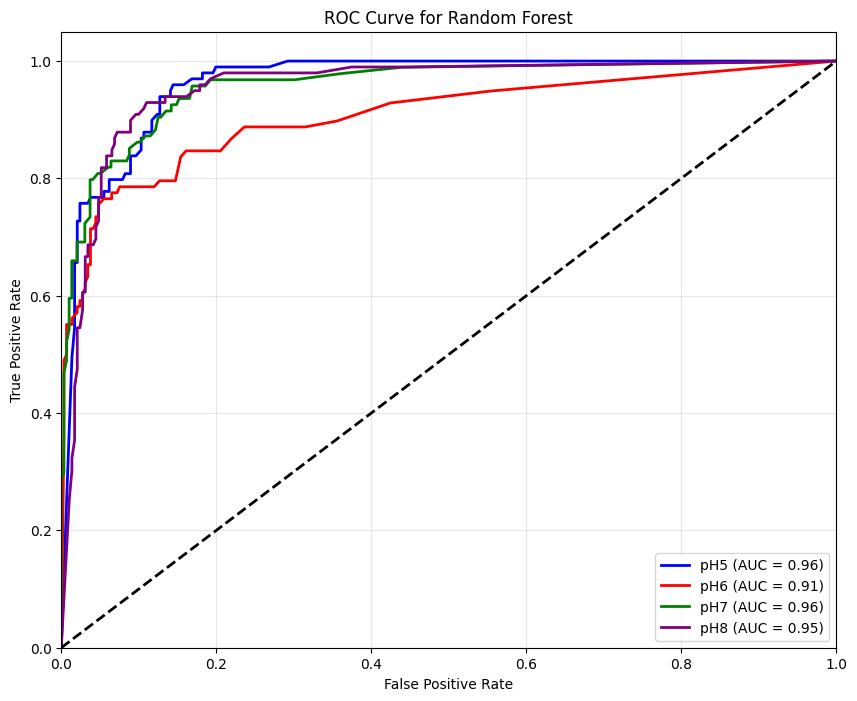

In [7]:
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle


# ----------------------------------
# 📉 ROC CURVES FOR RANDOM FOREST MODEL
# ----------------------------------

def plot_roc_curve(y_true, y_score, model_name, class_names):
    """Plot ROC curves for multi-class classification."""
    # Binarize the labels for one-vs-rest ROC
    y_bin = label_binarize(y_true, classes=range(len(class_names)))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'purple'])
    
    for i, color, cls in zip(range(len(class_names)), colors, class_names):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{cls} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

print("\n📉 Generating ROC curves for Random Forest model...")
# Get Random Forest probability predictions
rf_probs = rf.predict_proba(X_test_rf)

# Plot ROC curve for Random Forest
plot_roc_curve(y_test_rf, rf_probs, "Random Forest", ["pH5", "pH6", "pH7", "pH8"])